# Regression - GLMs


## Exercise 1: Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

- **FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.
- **LIVE_BAIT:** A binary variable indicating whether live bait was used.
- **CAMPER:** Whether the fishing group used a camper van.
- **PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.
- **CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (`FISH_COUNT`) by a camping group based on the values of `LIVE_BAIT`, `CAMPER`, `PERSONS` and `CHILDREN` variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort we went through to find a fish dataset for a count problem pun. 😛

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st



In [164]:
# exercise 1
data = pd.read_csv('../data/fish.csv')
df = data.copy()
df.head()

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1


In [165]:
df.isna().sum()

LIVE_BAIT     0
CAMPER        0
PERSONS       0
CHILDREN      0
FISH_COUNT    0
dtype: int64

In [166]:
df.rename(columns= {'A' : 'LIVE_BAIT', 'camper' :'CAMPER',
           'persons' : 'PERSONS', 'children' :'CHILDREN', 'fish_count' : 'FISH_COUNT'}, inplace=True)
df.head()

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1


(0.0, 40.0)

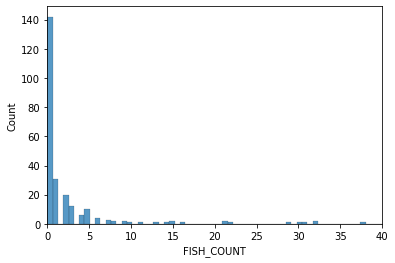

In [167]:
sns.histplot(df.FISH_COUNT)#to show target value distribution
plt.xlim(0, 40)#to show better view

In [168]:
df.columns

Index(['LIVE_BAIT', 'CAMPER', 'PERSONS', 'CHILDREN', 'FISH_COUNT'], dtype='object')

<AxesSubplot:xlabel='LIVE_BAIT', ylabel='FISH_COUNT'>

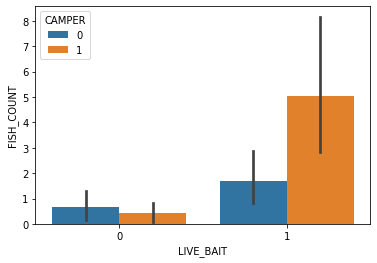

In [169]:
#campers with bait caught more fish
sns.barplot(x = 'LIVE_BAIT', y= 'FISH_COUNT', data=df, hue='CAMPER')

(0.0, 40.0)

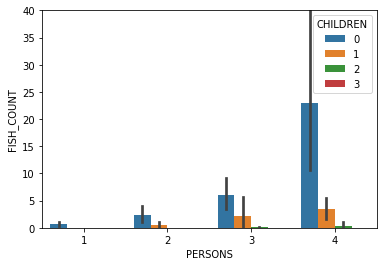

In [170]:
#could be clearly seen the more people without children the more fishing
sns.barplot(x = 'PERSONS', y= 'FISH_COUNT', data=df, hue='CHILDREN')
plt.ylim(0,40)

In [171]:
x = df[['LIVE_BAIT', 'CAMPER', 'PERSONS', 'CHILDREN']]
y = df.FISH_COUNT

In [182]:
est = sm.OLS(y, sm.add_constant(x)).fit()
est.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     14.86
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           6.96e-11
Time:                        22:03:27   Log-Likelihood:                -940.59
No. Observations:                 250   AIC:                             1891.
Df Residuals:                     245   BIC:                             1909.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1847      2.508     -3.662      0.000     -14.124      -4.245
LIVE_BAIT      2.9480      1.951      1.511      0.132      -0.894       6.790
CAMPER         3.0077      1.360      2.212      0.028       0.329       5.686
PERSONS        4.7587      0.716      6.646      0.000       3.348       6.169
CHILDREN      -5.6503      0.936     -6.034      0.000      -7.495      -3.806
==============================================================================
Omnibus:                      425.798   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121332.736
Skew:                           8.922   Prob(JB):                         0.00
Kurtosis:                     109.440   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [191]:
ypred = est.predict(sm.add_constant(x))

C:\Users\zmaso\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

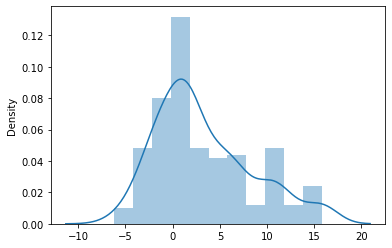

In [192]:
sns.distplot(est.predict(sm.add_constant(x)))

In [174]:
#there is exotic data = there is  a spike on zero
#to solve the problem: two stage modelling has been used
#stage one: use the exotic data part as a predictor for the rest of the data not being in zero part
x1 = x.copy()

est1 = sm.Logit((y > 0).astype(int), sm.add_constant(x1)).fit()
est1.summary()


x1 = pd.DataFrame(sm.add_constant(x1))
x1['stage1'] = est1.predict(x1)
x1.columns = ['const', 'LIVE_BAIT', 'CAMPER', 'PERSONS', 'CHILDREN', 'stage1']

# Stage 2
est2 = sm.OLS(y, x1).fit()
est2.summary()

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.05
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           2.90e-11
Time:                        22:02:31   Log-Likelihood:                -938.12
No. Observations:                 250   AIC:                             1888.
Df Residuals:                     244   BIC:                             1909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4807      2.556     -4.100      0.000     -15.516      -5.445
LIVE_BAIT      6.3331      2.468      2.566      0.011       1.471      11.195
CAMPER         6.9381      2.233      3.108      0.002       2.541      11.336
PERSONS        9.5638      2.288      4.180      0.000       5.058      14.070
CHILDREN     -14.1342      3.950     -3.578      0.000     -21.915      -6.353
stage1       -23.8062     10.774     -2.210      0.028     -45.028      -2.584
==============================================================================
Omnibus:                      420.458   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114163.931
Skew:                           8.715   Prob(JB):                         0.00
Kurtosis:                     106.228   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\zmaso\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

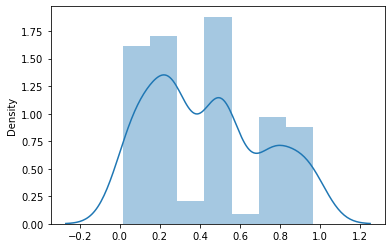

In [194]:
sns.distplot(est1.predict(sm.add_constant(x)))

C:\Users\zmaso\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

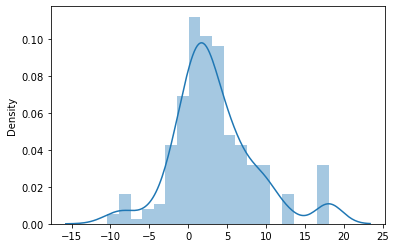

In [176]:
sns.distplot(est2.predict(x1))#shows the same fitting without two stage regression

In [177]:
#among the coeficients, children has the most effect on taget value an d then the number of people is more effective.


<AxesSubplot:>

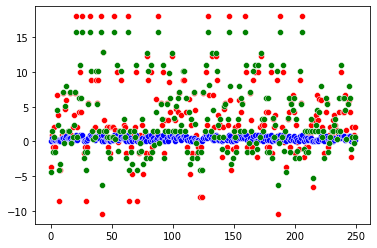

In [200]:
#denoting there is no defference between prediction befre and after using the two stages regression
sns.scatterplot(x=range(0, len(x.index)), y=est2.predict(x1), color='red')
#scattered around zero beacause it is predicted for zero fisshing
sns.scatterplot(x=range(0, len(x.index)), y=est1.predict(sm.add_constant(x)), color='blue')
sns.scatterplot(x=range(0, len(x.index)), y=est.predict(sm.add_constant(x)), color='green')


     There are negative scattered points under zero which is not meaningful. 
     The visualization's result approved the model's result for children's effect 
     on decreasing fishing. people's number would be helpful to increase the fishing rate. 

N.B. Please appreciate the effort we went through to find a fish dataset for a count problem pun. 😛

          At the end it is appreciated and acknowledged for pretious collectting data 
          to scrutinize the fishing rate just for human right!! 😁